In [1]:
import os

dataset_path = "D:/Data Arief"  # sesuaikan dengan path dataset di komputer lokal

for folder in ['train', 'val', 'test']:
    subfolder = os.path.join(folder)  # contoh: train/train
    print(f"Data {folder}:")

    for label in ['NORMAL', 'TUBERCULOSIS']:
        label_path = os.path.join(dataset_path, subfolder, label)
        if os.path.isdir(label_path):
            print(f"  {label}: {len(os.listdir(label_path))} images")
        else:
            print(f"  {label}: Folder not found")
    print("-" * 40)


Data train:
  NORMAL: 4667 images
  TUBERCULOSIS: 3573 images
----------------------------------------
Data val:
  NORMAL: 274 images
  TUBERCULOSIS: 207 images
----------------------------------------
Data test:
  NORMAL: 548 images
  TUBERCULOSIS: 417 images
----------------------------------------


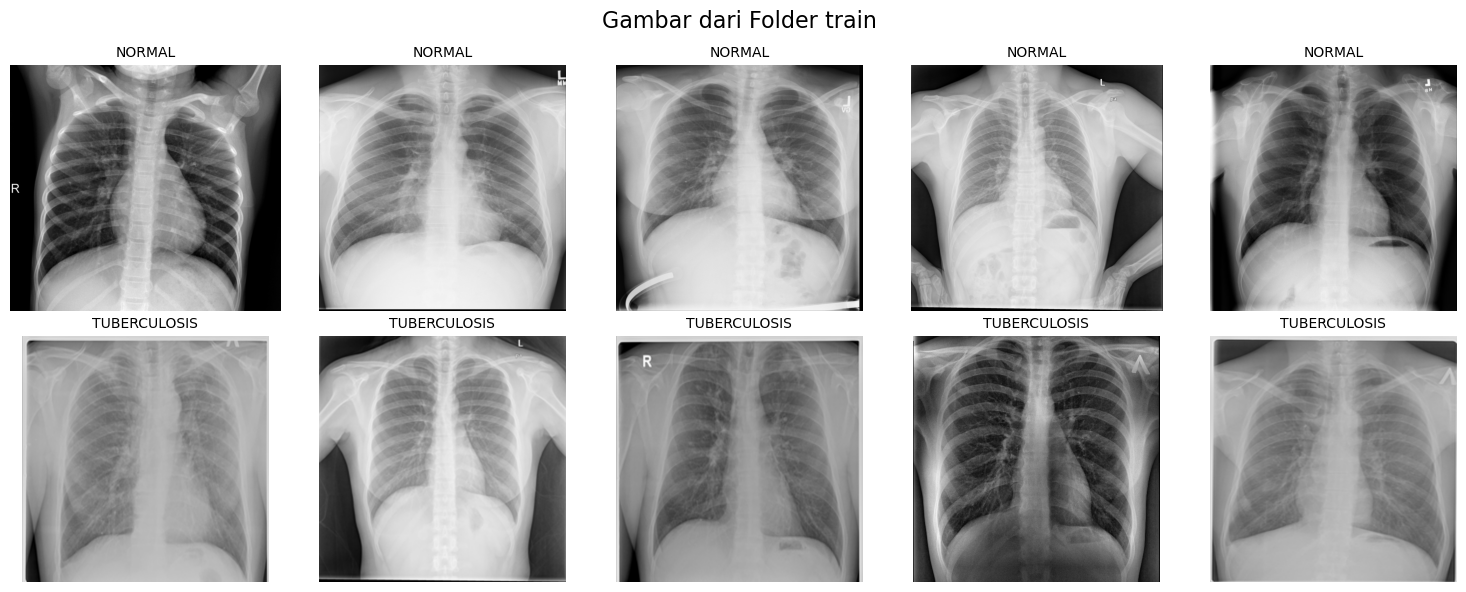

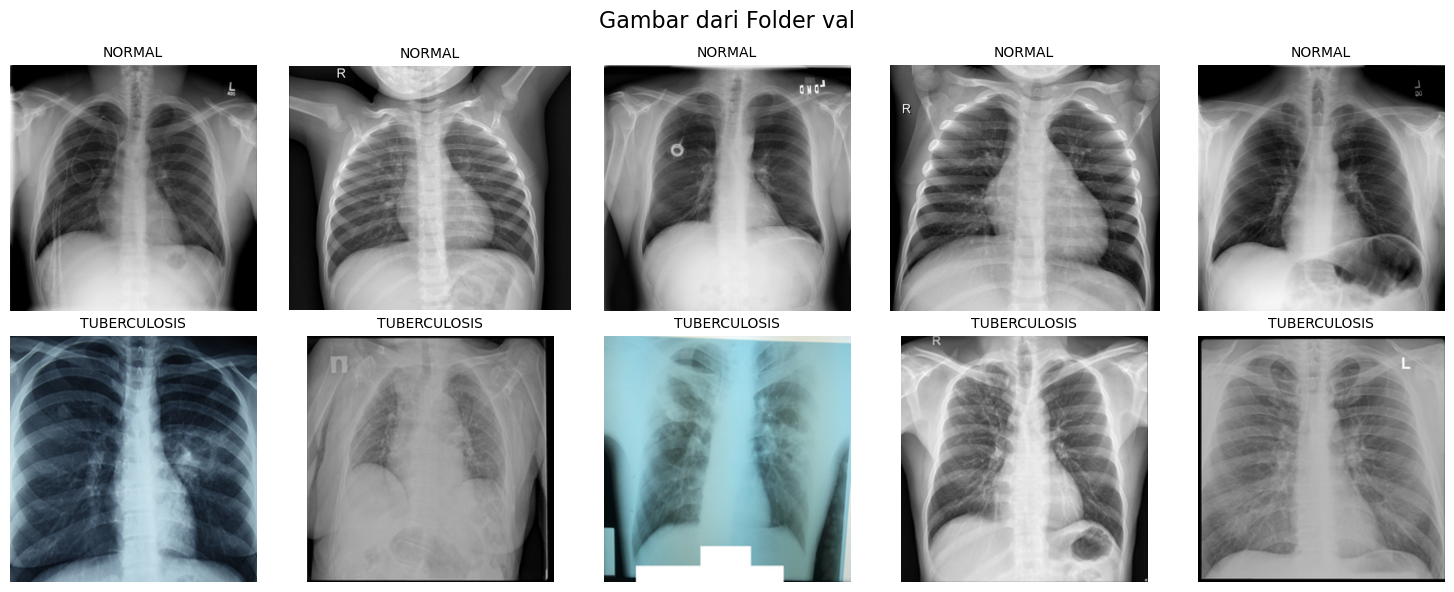

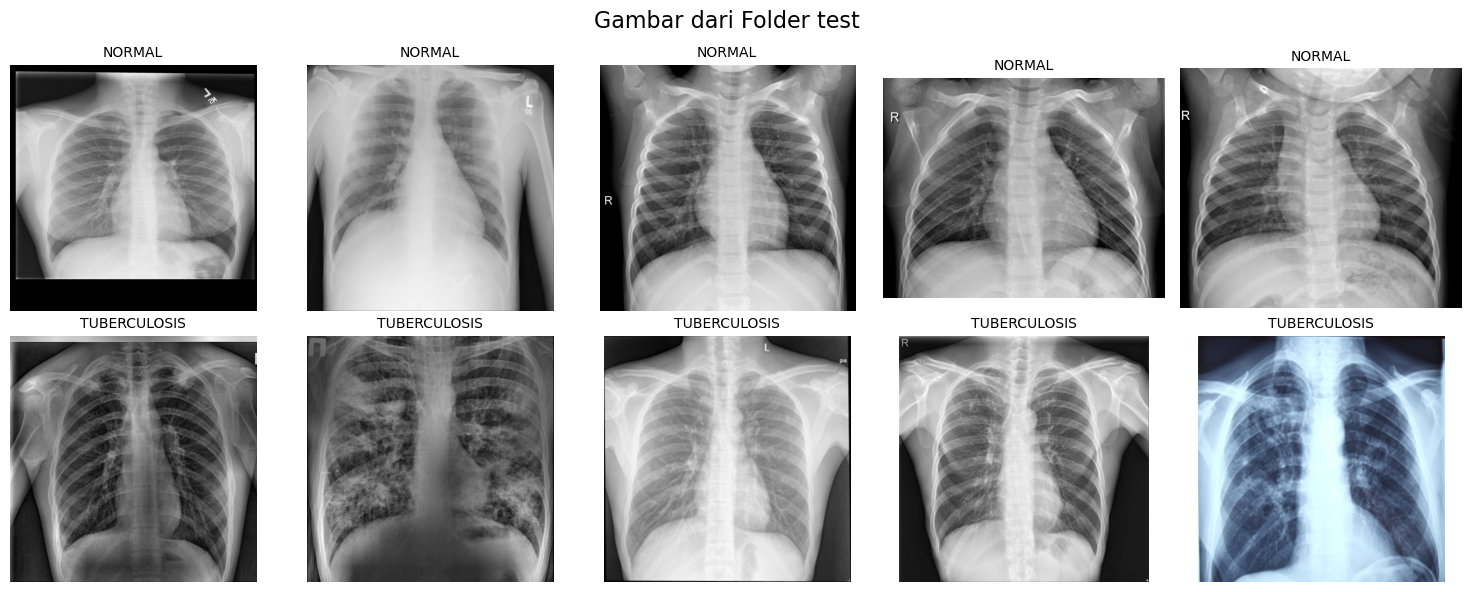

In [2]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Tentukan path ke folder dataset
dataset_path = 'D:/Data Arief'

# Fungsi untuk menampilkan gambar dari folder tertentu
def display_images_from_folder(dataset_path, folder_name):
    # Path ke folder citra NORMAL dan TUBERCULOSIS untuk train, val, atau test
    normal_path = os.path.join(dataset_path, folder_name, 'NORMAL')
    tuberculosis_path = os.path.join(dataset_path, folder_name, 'TUBERCULOSIS')

    # Ambil 5 file gambar secara acak dari masing-masing folder
    normal_images = random.sample(os.listdir(normal_path), 5)
    tuberculosis_images = random.sample(os.listdir(tuberculosis_path), 5)

    # Buat figure untuk menampilkan gambar
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(f'Gambar dari Folder {folder_name}', fontsize=16)

    # Menampilkan 5 gambar NORMAL
    for i, image_file in enumerate(normal_images):
        img_path = os.path.join(normal_path, image_file)
        img = Image.open(img_path).convert("RGB")  # Pastikan gambar dibaca dalam mode RGB
        axes[0, i].imshow(img)
        axes[0, i].set_title("NORMAL", fontsize=10)
        axes[0, i].axis('off')

    # Menampilkan 5 gambar TUBERCULOSIS
    for i, image_file in enumerate(tuberculosis_images):
        img_path = os.path.join(tuberculosis_path, image_file)
        img = Image.open(img_path).convert("RGB")  # Pastikan gambar dibaca dalam mode RGB
        axes[1, i].imshow(img)
        axes[1, i].set_title("TUBERCULOSIS", fontsize=10)
        axes[1, i].axis('off')

    # Menampilkan semua gambar
    plt.tight_layout()
    plt.show()

# Tampilkan gambar dari masing-masing folder: train, val, test
for folder in ['train', 'val', 'test']:
    display_images_from_folder(dataset_path, folder)

PREPROCESSING

In [3]:
import os
import cv2
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

In [4]:
def crop_image(image):
    img_array = np.array(image)
    non_black_pixels = np.where(img_array != 0)
    top, left = np.min(non_black_pixels[0]), np.min(non_black_pixels[1])
    bottom, right = np.max(non_black_pixels[0]), np.max(non_black_pixels[1])
    cropped_img = image.crop((left, top, right, bottom))
    return cropped_img

In [5]:
# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

Displaying 8 random images from the train dataset:


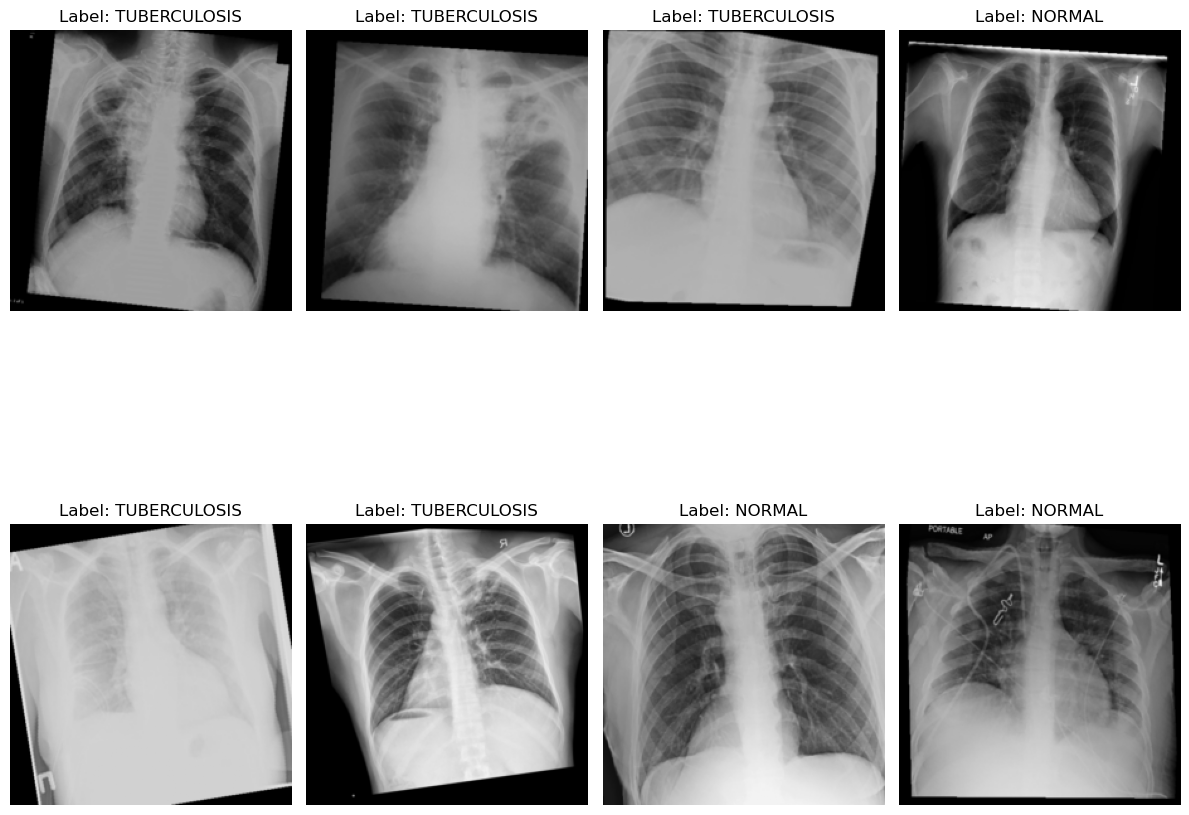

In [6]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# --- Definisikan transformasi ---

# Augmentasi hanya untuk data train
train_transforms = transforms.Compose([
    transforms.Lambda(crop_image),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], 
    #                      std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Lambda(crop_image),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], 
    #                      std=[0.229, 0.224, 0.225])
])

# --- Load dataset dari folder yang sudah terpisah ---

dataset_path = "D:/Data Arief"

train_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'val'), transform=val_test_transforms)
test_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'test'), transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

# Fungsi menampilkan gambar (tidak perlu diubah)
def show_random_images_from_loader(loader, num_images=8):
    for images, labels in loader:
        images = images.cpu().numpy()
        images = np.transpose(images, (0, 2, 3, 1))
        plt.figure(figsize=(12, 12))
        for i in range(num_images):
            plt.subplot(2, 4, i + 1)
            img = images[i]
            # img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
            img = np.clip(img, 0, 1)
            label = 'NORMAL' if labels[i].item() == 0 else 'TUBERCULOSIS'
            plt.imshow(img)
            plt.title(f"Label: {label}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
        break

print("Displaying 8 random images from the train dataset:")
show_random_images_from_loader(train_loader, num_images=8)

BUILD UP MODEL

In [7]:
import math
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

c:\Users\LAB Viskom Umum\anaconda3\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [8]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [9]:
def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

def window_partition_noreshape(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (B, num_windows_h, num_windows_w, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous()
    return windows

def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

In [10]:
def get_roll_masks(H, W, window_size, shift_size):
    #####################################
    # move to top-left
    img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
    h_slices = (slice(0, H-window_size),
                slice(H-window_size, H-shift_size),
                slice(H-shift_size, H))
    w_slices = (slice(0, W-window_size),
                slice(W-window_size, W-shift_size),
                slice(W-shift_size, W))
    cnt = 0
    for h in h_slices:
        for w in w_slices:
            img_mask[:, h, w, :] = cnt
            cnt += 1

    mask_windows = window_partition(img_mask, window_size)  # nW, window_size, window_size, 1
    mask_windows = mask_windows.view(-1, window_size * window_size)
    attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
    attn_mask_tl = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

    ####################################
    # move to top right
    img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
    h_slices = (slice(0, H-window_size),
                slice(H-window_size, H-shift_size),
                slice(H-shift_size, H))
    w_slices = (slice(0, shift_size),
                slice(shift_size, window_size),
                slice(window_size, W))
    cnt = 0
    for h in h_slices:
        for w in w_slices:
            img_mask[:, h, w, :] = cnt
            cnt += 1

    mask_windows = window_partition(img_mask, window_size)  # nW, window_size, window_size, 1
    mask_windows = mask_windows.view(-1, window_size * window_size)
    attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
    attn_mask_tr = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

    ####################################
    # move to bottom left
    img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
    h_slices = (slice(0, shift_size),
                slice(shift_size, window_size),
                slice(window_size, H))
    w_slices = (slice(0, W-window_size),
                slice(W-window_size, W-shift_size),
                slice(W-shift_size, W))
    cnt = 0
    for h in h_slices:
        for w in w_slices:
            img_mask[:, h, w, :] = cnt
            cnt += 1

    mask_windows = window_partition(img_mask, window_size)  # nW, window_size, window_size, 1
    mask_windows = mask_windows.view(-1, window_size * window_size)
    attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
    attn_mask_bl = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

    ####################################
    # move to bottom right
    img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
    h_slices = (slice(0, shift_size),
                slice(shift_size, window_size),
                slice(window_size, H))
    w_slices = (slice(0, shift_size),
                slice(shift_size, window_size),
                slice(window_size, W))
    cnt = 0
    for h in h_slices:
        for w in w_slices:
            img_mask[:, h, w, :] = cnt
            cnt += 1

    mask_windows = window_partition(img_mask, window_size)  # nW, window_size, window_size, 1
    mask_windows = mask_windows.view(-1, window_size * window_size)
    attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
    attn_mask_br = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

    # append all
    attn_mask_all = torch.cat((attn_mask_tl, attn_mask_tr, attn_mask_bl, attn_mask_br), -1)
    return attn_mask_all

In [11]:
def get_relative_position_index(q_windows, k_windows):
    """
    Args:
        q_windows: tuple (query_window_height, query_window_width)
        k_windows: tuple (key_window_height, key_window_width)

    Returns:
        relative_position_index: query_window_height*query_window_width, key_window_height*key_window_width
    """
    # get pair-wise relative position index for each token inside the window
    coords_h_q = torch.arange(q_windows[0])
    coords_w_q = torch.arange(q_windows[1])
    coords_q = torch.stack(torch.meshgrid([coords_h_q, coords_w_q]))  # 2, Wh_q, Ww_q

    coords_h_k = torch.arange(k_windows[0])
    coords_w_k = torch.arange(k_windows[1])
    coords_k = torch.stack(torch.meshgrid([coords_h_k, coords_w_k]))  # 2, Wh, Ww

    coords_flatten_q = torch.flatten(coords_q, 1)  # 2, Wh_q*Ww_q
    coords_flatten_k = torch.flatten(coords_k, 1)  # 2, Wh_k*Ww_k

    relative_coords = coords_flatten_q[:, :, None] - coords_flatten_k[:, None, :]  # 2, Wh_q*Ww_q, Wh_k*Ww_k
    relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh_q*Ww_q, Wh_k*Ww_k, 2
    relative_coords[:, :, 0] += k_windows[0] - 1  # shift to start from 0
    relative_coords[:, :, 1] += k_windows[1] - 1
    relative_coords[:, :, 0] *= (q_windows[1] + k_windows[1]) - 1
    relative_position_index = relative_coords.sum(-1)  #  Wh_q*Ww_q, Wh_k*Ww_k
    return relative_position_index

In [12]:
class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.

    Args:
        dim (int): Number of input channels.
        expand_size (int): The expand size at focal level 1.
        window_size (tuple[int]): The height and width of the window.
        focal_window (int): Focal region size.
        focal_level (int): Focal attention level.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
        pool_method (str): window pooling method. Default: none
    """

    def __init__(self, dim, expand_size, window_size, focal_window, focal_level, num_heads,
                    qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0., pool_method="none"):

        super().__init__()
        self.dim = dim
        self.expand_size = expand_size
        self.window_size = window_size  # Wh, Ww
        self.pool_method = pool_method
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.focal_level = focal_level
        self.focal_window = focal_window

        # define a parameter table of relative position bias for each window
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        if self.expand_size > 0 and focal_level > 0:
            # define a parameter table of position bias between window and its fine-grained surroundings
            self.window_size_of_key = self.window_size[0] * self.window_size[1] if self.expand_size == 0 else \
                (4 * self.window_size[0] * self.window_size[1] - 4 * (self.window_size[0] -  self.expand_size) * (self.window_size[0] -  self.expand_size))
            self.relative_position_bias_table_to_neighbors = nn.Parameter(
                torch.zeros(1, num_heads, self.window_size[0] * self.window_size[1], self.window_size_of_key))  # Wh*Ww, nH, nSurrounding
            trunc_normal_(self.relative_position_bias_table_to_neighbors, std=.02)

            # get mask for rolled k and rolled v
            mask_tl = torch.ones(self.window_size[0], self.window_size[1]); mask_tl[:-self.expand_size, :-self.expand_size] = 0
            mask_tr = torch.ones(self.window_size[0], self.window_size[1]); mask_tr[:-self.expand_size, self.expand_size:] = 0
            mask_bl = torch.ones(self.window_size[0], self.window_size[1]); mask_bl[self.expand_size:, :-self.expand_size] = 0
            mask_br = torch.ones(self.window_size[0], self.window_size[1]); mask_br[self.expand_size:, self.expand_size:] = 0
            mask_rolled = torch.stack((mask_tl, mask_tr, mask_bl, mask_br), 0).flatten(0)
            self.register_buffer("valid_ind_rolled", mask_rolled.nonzero().view(-1))

        if pool_method != "none" and focal_level > 1:
            self.relative_position_bias_table_to_windows = nn.ParameterList()
            self.unfolds = nn.ModuleList()

            # build relative position bias between local patch and pooled windows
            for k in range(focal_level-1):
                stride = 2**k
                kernel_size = 2*(self.focal_window // 2) + 2**k + (2**k-1)
                # define unfolding operations
                self.unfolds += [nn.Unfold(
                    kernel_size=(kernel_size, kernel_size),
                    stride=stride, padding=kernel_size // 2)
                ]

                # define relative position bias table
                relative_position_bias_table_to_windows = nn.Parameter(
                    torch.zeros(
                        self.num_heads,
                        (self.window_size[0] + self.focal_window + 2**k - 2) * (self.window_size[1] + self.focal_window + 2**k - 2),
                        )
                )
                trunc_normal_(relative_position_bias_table_to_windows, std=.02)
                self.relative_position_bias_table_to_windows.append(relative_position_bias_table_to_windows)

                # define relative position bias index
                relative_position_index_k = get_relative_position_index(self.window_size, to_2tuple(self.focal_window + 2**k - 1))
                self.register_buffer("relative_position_index_{}".format(k), relative_position_index_k)

                # define unfolding index for focal_level > 0
                if k > 0:
                    mask = torch.zeros(kernel_size, kernel_size); mask[(2**k)-1:, (2**k)-1:] = 1
                    self.register_buffer("valid_ind_unfold_{}".format(k), mask.flatten(0).nonzero().view(-1))

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x_all, mask_all=None):
        """
        Args:
            x_all (list[Tensors]): input features at different granularity
            mask_all (list[Tensors/None]): masks for input features at different granularity
        """
        x = x_all[0] #

        B, nH, nW, C = x.shape
        qkv = self.qkv(x).reshape(B, nH, nW, 3, C).permute(3, 0, 1, 2, 4).contiguous()
        q, k, v = qkv[0], qkv[1], qkv[2]  # B, nH, nW, C

        # partition q map
        (q_windows, k_windows, v_windows) = map(
            lambda t: window_partition(t, self.window_size[0]).view(
            -1, self.window_size[0] * self.window_size[0], self.num_heads, C // self.num_heads
            ).transpose(1, 2),
            (q, k, v)
        )

        if self.expand_size > 0 and self.focal_level > 0:
            (k_tl, v_tl) = map(
                lambda t: torch.roll(t, shifts=(-self.expand_size, -self.expand_size), dims=(1, 2)), (k, v)
            )
            (k_tr, v_tr) = map(
                lambda t: torch.roll(t, shifts=(-self.expand_size, self.expand_size), dims=(1, 2)), (k, v)
            )
            (k_bl, v_bl) = map(
                lambda t: torch.roll(t, shifts=(self.expand_size, -self.expand_size), dims=(1, 2)), (k, v)
            )
            (k_br, v_br) = map(
                lambda t: torch.roll(t, shifts=(self.expand_size, self.expand_size), dims=(1, 2)), (k, v)
            )

            (k_tl_windows, k_tr_windows, k_bl_windows, k_br_windows) = map(
                lambda t: window_partition(t, self.window_size[0]).view(-1, self.window_size[0] * self.window_size[0], self.num_heads, C // self.num_heads),
                (k_tl, k_tr, k_bl, k_br)
            )
            (v_tl_windows, v_tr_windows, v_bl_windows, v_br_windows) = map(
                lambda t: window_partition(t, self.window_size[0]).view(-1, self.window_size[0] * self.window_size[0], self.num_heads, C // self.num_heads),
                (v_tl, v_tr, v_bl, v_br)
            )
            k_rolled = torch.cat((k_tl_windows, k_tr_windows, k_bl_windows, k_br_windows), 1).transpose(1, 2)
            v_rolled = torch.cat((v_tl_windows, v_tr_windows, v_bl_windows, v_br_windows), 1).transpose(1, 2)

            # mask out tokens in current window
            k_rolled = k_rolled[:, :, self.valid_ind_rolled]
            v_rolled = v_rolled[:, :, self.valid_ind_rolled]
            k_rolled = torch.cat((k_windows, k_rolled), 2)
            v_rolled = torch.cat((v_windows, v_rolled), 2)
        else:
            k_rolled = k_windows; v_rolled = v_windows;

        if self.pool_method != "none" and self.focal_level > 1:
            k_pooled = []
            v_pooled = []
            for k in range(self.focal_level-1):
                stride = 2**k
                x_window_pooled = x_all[k+1]  # B, nWh, nWw, C
                nWh, nWw = x_window_pooled.shape[1:3]

                # generate mask for pooled windows
                mask = x_window_pooled.new(nWh, nWw).fill_(1)
                unfolded_mask = self.unfolds[k](mask.unsqueeze(0).unsqueeze(1)).view(
                    1, 1, self.unfolds[k].kernel_size[0], self.unfolds[k].kernel_size[1], -1).permute(0, 4, 2, 3, 1).contiguous().\
                    view(nWh*nWw // stride // stride, -1, 1)

                if k > 0:
                    valid_ind_unfold_k = getattr(self, "valid_ind_unfold_{}".format(k))
                    unfolded_mask = unfolded_mask[:, valid_ind_unfold_k]

                x_window_masks = unfolded_mask.flatten(1).unsqueeze(0)
                x_window_masks = x_window_masks.masked_fill(x_window_masks == 0, float(-100.0)).masked_fill(x_window_masks > 0, float(0.0))
                mask_all[k+1] = x_window_masks

                # generate k and v for pooled windows
                qkv_pooled = self.qkv(x_window_pooled).reshape(B, nWh, nWw, 3, C).permute(3, 0, 4, 1, 2).contiguous()
                k_pooled_k, v_pooled_k = qkv_pooled[1], qkv_pooled[2]  # B, C, nWh, nWw


                (k_pooled_k, v_pooled_k) = map(
                    lambda t: self.unfolds[k](t).view(
                    B, C, self.unfolds[k].kernel_size[0], self.unfolds[k].kernel_size[1], -1).permute(0, 4, 2, 3, 1).contiguous().\
                    view(-1, self.unfolds[k].kernel_size[0]*self.unfolds[k].kernel_size[1], self.num_heads, C // self.num_heads).transpose(1, 2),
                    (k_pooled_k, v_pooled_k)  # (B x (nH*nW)) x nHeads x (unfold_wsize x unfold_wsize) x head_dim
                )

                if k > 0:
                    (k_pooled_k, v_pooled_k) = map(
                        lambda t: t[:, :, valid_ind_unfold_k], (k_pooled_k, v_pooled_k)
                    )

                k_pooled += [k_pooled_k]
                v_pooled += [v_pooled_k]
            k_all = torch.cat([k_rolled] + k_pooled, 2)
            v_all = torch.cat([v_rolled] + v_pooled, 2)
        else:
            k_all = k_rolled
            v_all = v_rolled

        N = k_all.shape[-2]
        q_windows = q_windows * self.scale
        attn = (q_windows @ k_all.transpose(-2, -1))  # B*nW, nHead, window_size*window_size, focal_window_size*focal_window_size

        window_area = self.window_size[0] * self.window_size[1]
        window_area_rolled = k_rolled.shape[2]

        # add relative position bias for tokens inside window
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn[:, :, :window_area, :window_area] = attn[:, :, :window_area, :window_area] + relative_position_bias.unsqueeze(0)

        # add relative position bias for patches inside a window
        if self.expand_size > 0 and self.focal_level > 0:
            attn[:, :, :window_area, window_area:window_area_rolled] = attn[:, :, :window_area, window_area:window_area_rolled] + self.relative_position_bias_table_to_neighbors

        if self.pool_method != "none" and self.focal_level > 1:
            # add relative position bias for different windows in an image
            offset = window_area_rolled
            for k in range(self.focal_level-1):
                # add relative position bias
                relative_position_index_k = getattr(self, 'relative_position_index_{}'.format(k))
                relative_position_bias_to_windows = self.relative_position_bias_table_to_windows[k][:, relative_position_index_k.view(-1)].view(
                    -1, self.window_size[0] * self.window_size[1], (self.focal_window+2**k-1)**2,
                ) # nH, NWh*NWw,focal_region*focal_region
                attn[:, :, :window_area, offset:(offset + (self.focal_window+2**k-1)**2)] = \
                    attn[:, :, :window_area, offset:(offset + (self.focal_window+2**k-1)**2)] + relative_position_bias_to_windows.unsqueeze(0)
                # add attentional mask
                if mask_all[k+1] is not None:
                    attn[:, :, :window_area, offset:(offset + (self.focal_window+2**k-1)**2)] = \
                        attn[:, :, :window_area, offset:(offset + (self.focal_window+2**k-1)**2)] + \
                            mask_all[k+1][:, :, None, None, :].repeat(attn.shape[0] // mask_all[k+1].shape[1], 1, 1, 1, 1).view(-1, 1, 1, mask_all[k+1].shape[-1])

                offset += (self.focal_window+2**k-1)**2

        if mask_all[0] is not None:
            nW = mask_all[0].shape[0]
            attn = attn.view(attn.shape[0] // nW, nW, self.num_heads, window_area, N)
            attn[:, :, :, :, :window_area] = attn[:, :, :, :, :window_area] + mask_all[0][None, :, None, :, :]
            attn = attn.view(-1, self.num_heads, window_area, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v_all).transpose(1, 2).reshape(attn.shape[0], window_area, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N, window_size, unfold_size):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        if self.pool_method != "none" and self.focal_level > 1:
            flops += self.num_heads * N * (self.dim // self.num_heads) * (unfold_size * unfold_size)
        if self.expand_size > 0 and self.focal_level > 0:
            flops += self.num_heads * N * (self.dim // self.num_heads) * ((window_size + 2*self.expand_size)**2-window_size**2)

        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        if self.pool_method != "none" and self.focal_level > 1:
            flops += self.num_heads * N * (self.dim // self.num_heads) * (unfold_size * unfold_size)
        if self.expand_size > 0 and self.focal_level > 0:
            flops += self.num_heads * N * (self.dim // self.num_heads) * ((window_size + 2*self.expand_size)**2-window_size**2)

        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops

In [13]:
class FocalTransformerBlock(nn.Module):
    r""" Focal Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        expand_size (int): expand size at first focal level (finest level).
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
        pool_method (str): window pooling method. Default: none, options: [none|fc|conv]
        focal_level (int): number of focal levels. Default: 1.
        focal_window (int): region size of focal attention. Default: 1
        use_layerscale (bool): whether use layer scale for training stability. Default: False
        layerscale_value (float): scaling value for layer scale. Default: 1e-4
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, expand_size=0, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm, pool_method="none",
                 focal_level=1, focal_window=1, use_layerscale=False, layerscale_value=1e-4):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.expand_size = expand_size
        self.mlp_ratio = mlp_ratio
        self.pool_method = pool_method
        self.focal_level = focal_level
        self.focal_window = focal_window
        self.use_layerscale = use_layerscale

        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.expand_size = 0
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.window_size_glo = self.window_size

        self.pool_layers = nn.ModuleList()
        if self.pool_method != "none":
            for k in range(self.focal_level-1):
                window_size_glo = math.floor(self.window_size_glo / (2 ** k))
                if self.pool_method == "fc":
                    self.pool_layers.append(nn.Linear(window_size_glo * window_size_glo, 1))
                    self.pool_layers[-1].weight.data.fill_(1./(window_size_glo * window_size_glo))
                    self.pool_layers[-1].bias.data.fill_(0)
                elif self.pool_method == "conv":
                    self.pool_layers.append(nn.Conv2d(dim, dim, kernel_size=window_size_glo, stride=window_size_glo, groups=dim))

        self.norm1 = norm_layer(dim)

        self.attn = WindowAttention(
            dim, expand_size=self.expand_size, window_size=to_2tuple(self.window_size),
            focal_window=focal_window, focal_level=focal_level, num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop, pool_method=pool_method)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None
        self.register_buffer("attn_mask", attn_mask)

        if self.use_layerscale:
            self.gamma_1 = nn.Parameter(layerscale_value * torch.ones((dim)), requires_grad=True)
            self.gamma_2 = nn.Parameter(layerscale_value * torch.ones((dim)), requires_grad=True)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # pad feature maps to multiples of window size
        pad_l = pad_t = 0
        pad_r = (self.window_size - W % self.window_size) % self.window_size
        pad_b = (self.window_size - H % self.window_size) % self.window_size
        if pad_r > 0 or pad_b > 0:
            x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b))

        B, H, W, C = x.shape

        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        x_windows_all = [shifted_x]
        x_window_masks_all = [self.attn_mask]

        if self.focal_level > 1 and self.pool_method != "none":
            # if we add coarser granularity and the pool method is not none
            for k in range(self.focal_level-1):
                window_size_glo = math.floor(self.window_size_glo / (2 ** k))
                pooled_h = math.ceil(H / self.window_size) * (2 ** k)
                pooled_w = math.ceil(W / self.window_size) * (2 ** k)
                H_pool = pooled_h * window_size_glo
                W_pool = pooled_w * window_size_glo

                x_level_k = shifted_x
                # trim or pad shifted_x depending on the required size
                if H > H_pool:
                    trim_t = (H - H_pool) // 2
                    trim_b = H - H_pool - trim_t
                    x_level_k = x_level_k[:, trim_t:-trim_b]
                elif H < H_pool:
                    pad_t = (H_pool - H) // 2
                    pad_b = H_pool - H - pad_t
                    x_level_k = F.pad(x_level_k, (0,0,0,0,pad_t,pad_b))

                if W > W_pool:
                    trim_l = (W - W_pool) // 2
                    trim_r = W - W_pool - trim_l
                    x_level_k = x_level_k[:, :, trim_l:-trim_r]
                elif W < W_pool:
                    pad_l = (W_pool - W) // 2
                    pad_r = W_pool - W - pad_l
                    x_level_k = F.pad(x_level_k, (0,0,pad_l,pad_r))

                x_windows_noreshape = window_partition_noreshape(x_level_k.contiguous(), window_size_glo) # B, nw, nw, window_size, window_size, C
                nWh, nWw = x_windows_noreshape.shape[1:3]
                if self.pool_method == "mean":
                    x_windows_pooled = x_windows_noreshape.mean([3, 4]) # B, nWh, nWw, C
                elif self.pool_method == "max":
                    x_windows_pooled = x_windows_noreshape.max(-2)[0].max(-2)[0].view(B, nWh, nWw, C) # B, nWh, nWw, C
                elif self.pool_method == "fc":
                    x_windows_noreshape = x_windows_noreshape.view(B, nWh, nWw, window_size_glo*window_size_glo, C).transpose(3, 4) # B, nWh, nWw, C, wsize**2
                    x_windows_pooled = self.pool_layers[k](x_windows_noreshape).flatten(-2) # B, nWh, nWw, C
                elif self.pool_method == "conv":
                    x_windows_noreshape = x_windows_noreshape.view(-1, window_size_glo, window_size_glo, C).permute(0, 3, 1, 2).contiguous() # B * nw * nw, C, wsize, wsize
                    x_windows_pooled = self.pool_layers[k](x_windows_noreshape).view(B, nWh, nWw, C) # B, nWh, nWw, C

                x_windows_all += [x_windows_pooled]
                x_window_masks_all += [None]

        attn_windows = self.attn(x_windows_all, mask_all=x_window_masks_all)  # nW*B, window_size*window_size, C

        attn_windows = attn_windows[:, :self.window_size ** 2]

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x[:, :self.input_resolution[0], :self.input_resolution[1]].contiguous().view(B, -1, C)

        # FFN
        x = shortcut + self.drop_path(x if (not self.use_layerscale) else (self.gamma_1 * x))
        x = x + self.drop_path(self.mlp(self.norm2(x)) if (not self.use_layerscale) else (self.gamma_2 * self.mlp(self.norm2(x))))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W

        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size, self.window_size, self.focal_window)

        if self.pool_method != "none" and self.focal_level > 1:
            for k in range(self.focal_level-1):
                window_size_glo = math.floor(self.window_size_glo / (2 ** k))
                nW_glo = nW * (2**k)
                # (sub)-window pooling
                flops += nW_glo * self.dim * window_size_glo * window_size_glo
                # qkv for global levels
                # NOTE: in our implementation, we pass the pooled window embedding to qkv embedding layer,
                # but theoritically, we only need to compute k and v.
                flops += nW_glo * self.dim * 3 * self.dim

        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops

In [14]:
class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        img_size (tuple[int]): Resolution of input feature.
        in_chans (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, img_size, in_chans=3, norm_layer=nn.LayerNorm, **kwargs):
        super().__init__()
        self.input_resolution = img_size
        self.dim = in_chans
        self.reduction = nn.Linear(4 * in_chans, 2 * in_chans, bias=False)
        self.norm = norm_layer(4 * in_chans)

    def forward(self, x):
        """
        x: B, C, H, W
        """
        B, C, H, W = x.shape

        x = x.permute(0, 2, 3, 1).contiguous()

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops

In [15]:
class BasicLayer(nn.Module):
    """ A basic Focal Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        expand_size (int): expand size for focal level 1.
        expand_layer (str): expand layer. Default: all
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4.0.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        pool_method (str): Window pooling method. Default: none.
        focal_level (int): Number of focal levels. Default: 1.
        focal_window (int): region size at each focal level. Default: 1.
        use_conv_embed (bool): whether use overlapped convolutional patch embedding layer. Default: False
        use_shift (bool): Whether use window shift as in Swin Transformer. Default: False
        use_pre_norm (bool): Whether use pre-norm before patch embedding projection for stability. Default: False
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        use_layerscale (bool): Whether use layer scale for stability. Default: False.
        layerscale_value (float): Layerscale value. Default: 1e-4.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size, expand_size, expand_layer="all",
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, pool_method="none",
                 focal_level=1, focal_window=1, use_conv_embed=False, use_shift=False, use_pre_norm=False,
                 downsample=None, use_checkpoint=False, use_layerscale=False, layerscale_value=1e-4):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        if expand_layer == "even":
            expand_factor = 0
        elif expand_layer == "odd":
            expand_factor = 1
        elif expand_layer == "all":
            expand_factor = -1

        # build blocks
        self.blocks = nn.ModuleList([
            FocalTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=(0 if (i % 2 == 0) else window_size // 2) if use_shift else 0,
                                 expand_size=0 if (i % 2 == expand_factor) else expand_size,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop,
                                 attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer,
                                 pool_method=pool_method,
                                 focal_level=focal_level,
                                 focal_window=focal_window,
                                 use_layerscale=use_layerscale,
                                 layerscale_value=layerscale_value)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(
                img_size=input_resolution, patch_size=2, in_chans=dim, embed_dim=2*dim,
                use_conv_embed=use_conv_embed, norm_layer=norm_layer, use_pre_norm=use_pre_norm,
                is_stem=False
            )
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)

        if self.downsample is not None:
            x = x.view(x.shape[0], self.input_resolution[0], self.input_resolution[1], -1).permute(0, 3, 1, 2).contiguous()
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops

In [16]:
class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        use_conv_embed (bool): Wherther use overlapped convolutional embedding layer. Default: False.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
        use_pre_norm (bool): Whether use pre-normalization before projection. Default: False
        is_stem (bool): Whether current patch embedding is stem. Default: False
    """

    def __init__(self, img_size=(224, 224), patch_size=4, in_chans=3, embed_dim=96,
                    use_conv_embed=False, norm_layer=None, use_pre_norm=False, is_stem=False):
        super().__init__()
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim
        self.use_pre_norm = use_pre_norm
        self.use_conv_embed = use_conv_embed

        if use_conv_embed:
            # if we choose to use conv embedding, then we treat the stem and non-stem differently
            if is_stem:
                kernel_size = 7; padding = 2; stride = 4
            else:
                kernel_size = 3; padding = 1; stride = 2
            self.kernel_size = kernel_size
            self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=kernel_size, stride=stride, padding=padding)
        else:
            self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)


        if self.use_pre_norm:
            if norm_layer is not None:
                self.pre_norm = nn.GroupNorm(1, in_chans)
            else:
                self.pre_norm = None

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."

        if self.use_pre_norm:
            x = self.pre_norm(x)

        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        if self.use_conv_embed:
            flops = Ho * Wo * self.embed_dim * self.in_chans * (self.kernel_size**2)
        else:
            flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops

In [17]:
class FocalTransformer(nn.Module):
    r""" Focal Transformer: Focal Self-attention for Local-Global Interactions in Vision Transformer

    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Focal Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
        use_shift (bool): Whether to use window shift proposed by Swin Transformer. We observe that using shift or not does not make difference to our Focal Transformer. Default: False
        focal_stages (list): Which stages to perform focal attention. Default: [0, 1, 2, 3], means all stages
        focal_levels (list): How many focal levels at all stages. Note that this excludes the finest-grain level. Default: [1, 1, 1, 1]
        focal_windows (list): The focal window size at all stages. Default: [7, 5, 3, 1]
        expand_stages (list): Which stages to expand the finest grain window. Default: [0, 1, 2, 3], means all stages
        expand_sizes (list): The expand size for the finest grain level. Default: [3, 3, 3, 3]
        expand_layer (str): Which layers we want to expand the window for the finest grain leve. This can save computational and memory cost without the loss of performance. Default: "all"
        use_conv_embed (bool): Whether use convolutional embedding. We noted that using convolutional embedding usually improve the performance, but we do not use it by default. Default: False
        use_layerscale (bool): Whether use layerscale proposed in CaiT. Default: False
        layerscale_value (float): Value for layer scale. Default: 1e-4
        use_pre_norm (bool): Whether use pre-norm in patch merging/embedding layer to control the feature magtigute. Default: False
    """
    def __init__(self,
                img_size=224,
                patch_size=4,
                in_chans=3,
                num_classes=2,
                embed_dim=96,
                depths=[2, 2, 6, 2],
                num_heads=[3, 6, 12, 24],
                window_size=7,
                mlp_ratio=4.,
                qkv_bias=True,
                qk_scale=None,
                drop_rate=0.,
                attn_drop_rate=0.,
                drop_path_rate=0.1,
                norm_layer=nn.LayerNorm,
                ape=False,
                patch_norm=True,
                use_checkpoint=False,
                use_shift=False,
                focal_stages=[0, 1, 2, 3],
                focal_levels=[1, 1, 1, 1],
                focal_windows=[7, 5, 3, 1],
                focal_pool="fc",
                expand_stages=[0, 1, 2, 3],
                expand_sizes=[3, 3, 3, 3],
                expand_layer="all",
                use_conv_embed=False,
                use_layerscale=False,
                layerscale_value=1e-4,
                use_pre_norm=False,
                **kwargs):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # split image into patches using either non-overlapped embedding or overlapped embedding
        self.patch_embed = PatchEmbed(
            img_size=to_2tuple(img_size), patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim, use_conv_embed=use_conv_embed, is_stem=True,
            norm_layer=norm_layer if self.patch_norm else None)

        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias,
                               qk_scale=qk_scale,
                               drop=drop_rate,
                               attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               pool_method=focal_pool if i_layer in focal_stages else "none",
                               downsample=PatchEmbed if (i_layer < self.num_layers - 1) else None,
                               focal_level=focal_levels[i_layer],
                               focal_window=focal_windows[i_layer],
                               expand_size=expand_sizes[i_layer],
                               expand_layer=expand_layer,
                               use_conv_embed=use_conv_embed,
                               use_shift=use_shift,
                               use_pre_norm=use_pre_norm,
                               use_checkpoint=use_checkpoint,
                               use_layerscale=use_layerscale,
                               layerscale_value=layerscale_value)
            self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table', 'relative_position_bias_table_to_neighbors', 'relative_position_bias_table_to_windows'}

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)
        x = self.norm(x)  # B L C
        x = self.avgpool(x.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        flops += self.num_features * self.num_classes
        return flops

In [18]:
def profile(model, inputs):
    from torch.profiler import profile, record_function, ProfilerActivity
    with profile(activities=[
            ProfilerActivity.CPU, ProfilerActivity.CUDA], with_stack=True, record_shapes=True) as prof:
        with record_function("model_inference"):
            model(inputs)

    print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=15))

if __name__ == '__main__':
    img_size = 224
    x = torch.rand(64, 3, img_size, img_size).cuda()

    # focal tiny
    model = FocalTransformer(img_size=img_size, embed_dim=96, depths=[2,2,6,2], drop_path_rate=0.2,
        focal_levels=[2,2,2,2], expand_sizes=[3,3,3,3], expand_layer="all",
        num_heads=[3,6,12,24],
        focal_windows=[7,5,3,1],
        window_size=7,
        use_conv_embed=True,
        use_shift=False,
    ).cuda()

    model.eval()

    flops = model.flops()
    print(f"number of GFLOPs: {flops / 1e9}")

    n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"number of params: {n_parameters}")

    profile(model, x)

c:\Users\LAB Viskom Umum\anaconda3\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


number of GFLOPs: 5.170083072
number of params: 30057782
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
              model_inference         9.76%      54.752ms       100.00%     561.175ms     561.175ms      16.399ms         2.92%     561.132ms     561.132ms             1  
                    aten::cat         6.76%      37.952ms         6.76%      37.952ms     593.000us      90.823ms        16.19%      90.823ms       1.419ms            64  
                 aten::im2col        10.95%      61.470ms        21.69%     121.71

TRAINING MODEL

In [19]:
import torch

# Jumlah gambar dalam kelas TRAINING
num_normal = 4642  # Jumlah gambar kelas NORMAL (training)
num_tuberculosis = 3548  # Jumlah gambar kelas TUBERCULOSIS (training)

# Total gambar dalam training set
total_images_train = num_normal + num_tuberculosis

# Hitung bobot untuk setiap kelas
weight_normal = total_images_train / (2 * num_normal)
weight_tuberculosis = total_images_train / (2 * num_tuberculosis)

# Adjust the weight for the TUBERCULOSIS class by multiplying by 1.1 (or 1.2 if needed)
weight_tuberculosis *= 1.2  # Increasing the weight for TUBERCULOSIS class

# Membuat tensor bobot untuk setiap kelas
class_weights = torch.tensor([weight_normal, weight_tuberculosis]).cuda()

In [20]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Tentukan model (jika Anda sudah memuat model sebelumnya)
model = FocalTransformer(
    img_size=224, patch_size=4, in_chans=3, embed_dim=96, depths=[2, 2, 6, 2],
    num_heads=[3,6,12,24], window_size=7, mlp_ratio=4.0
).cuda()

# Pastikan output layer (head) cocok untuk 2 kelas
model.head = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(model.num_features, 2)
).cuda()

# Loss function: misalnya CrossEntropyLoss untuk klasifikasi
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer: Misalnya Adam
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-2)

scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.3)

In [21]:
from torchinfo import summary

# Tampilkan struktur model
summary(model, input_size=(64, 3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
FocalTransformer                                   [64, 2]                   --
├─PatchEmbed: 1-1                                  [64, 3136, 96]            --
│    └─Conv2d: 2-1                                 [64, 96, 56, 56]          4,704
│    └─LayerNorm: 2-2                              [64, 3136, 96]            192
├─Dropout: 1-2                                     [64, 3136, 96]            --
├─ModuleList: 1-3                                  --                        --
│    └─BasicLayer: 2-3                             [64, 784, 192]            --
│    │    └─ModuleList: 3-1                        --                        263,502
│    │    └─PatchEmbed: 3-2                        [64, 784, 192]            74,304
│    └─BasicLayer: 2-4                             [64, 196, 384]            --
│    │    └─ModuleList: 3-3                        --                        969,372
│    │    └─Patch

In [22]:
# Pastikan device tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Inisialisasi model dan data (misal, model dan dataloader sudah ada)
model = model.to(device)  # Pastikan model dipindahkan ke device yang benar

Using device: cuda


In [ ]:
num_epochs = 30
best_val_accuracy = 0.0

epoch_losses = []
val_losses = []
train_accuracies = [] 
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0 
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()  # Pindahkan data ke device
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Hitung akurasi training
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy * 100:.2f}%")

    # === Validasi ===
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.cuda(), labels.cuda()  # Pindahkan data ke device
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_model.pth")  # Simpan model di direktori lokal
        print(f"Model disimpan! Val acc: {val_accuracy:.4f}")

    scheduler.step(val_accuracy)

# Print hasil akhir validation accuracy
print(f"\nValidation Accuracy After Training: {best_val_accuracy * 100:.2f}%")

Epoch [1/30], Loss: 0.6935, Training Accuracy: 56.65%
Validation Loss: 0.5856, Validation Accuracy: 67.78%
Model disimpan! Val acc: 0.6778
Epoch [2/30], Loss: 0.6027, Training Accuracy: 64.64%
Validation Loss: 0.6026, Validation Accuracy: 64.66%
Epoch [3/30], Loss: 0.5645, Training Accuracy: 69.03%
Validation Loss: 0.4779, Validation Accuracy: 78.59%
Model disimpan! Val acc: 0.7859
Epoch [4/30], Loss: 0.5038, Training Accuracy: 73.93%
Validation Loss: 0.4010, Validation Accuracy: 82.33%
Model disimpan! Val acc: 0.8233
Epoch [5/30], Loss: 0.4547, Training Accuracy: 77.60%
Validation Loss: 0.3771, Validation Accuracy: 85.03%
Model disimpan! Val acc: 0.8503


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(epoch_losses, label="Training Loss", marker='o', color='blue')
plt.plot(val_losses, label="Validation Loss", marker='s', color='red')
plt.title("Training & Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot([acc * 100 for acc in train_accuracies], label="Training Accuracy", marker='o', color='blue')
plt.plot([acc * 100 for acc in val_accuracies], label="Validation Accuracy", marker='s', color='green')
plt.title("Training vs Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

TESTING MODEL

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Inisialisasi ulang model dengan arsitektur identik
model = FocalTransformer(
    img_size=224,
    patch_size=4,
    in_chans=3,
    embed_dim=96,
    depths=[2, 2, 6, 2],
    num_heads=[3, 6, 12, 24],
    window_size=7,
    mlp_ratio=4.0
).cuda()  # Pastikan model dipindahkan ke device yang benar (CPU/GPU)

# Tambahkan struktur head yang sama seperti training
model.head = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(model.num_features, 2)
).cuda()  # Pindahkan head ke device yang benar

# Load bobot dari model terbaik
model.load_state_dict(torch.load("best_model.pth", map_location=device))  # Path lokal, pastikan model disimpan di path ini
model.eval()


In [ ]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Konversi ke NumPy array
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
classes = ['NORMAL', 'TUBERCULOSIS']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report (presisi, recall, f1)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# Accuracy (bisa juga ambil dari classification_report kalau mau ringkas)
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc*100:.2f}%")

In [ ]:
import matplotlib.pyplot as plt
import torch

model.eval()
classes = ['NORMAL', 'TUBERCULOSIS']

# Ambil satu batch dari test_loader
inputs, labels = next(iter(test_loader))
inputs, labels = inputs.cuda(), labels.cuda()

# Lakukan prediksi
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

# Menyimpan citra yang benar diprediksi (True Positives) dan yang salah diprediksi (False Positives)
correct_images = []
incorrect_images = []
correct_labels = []
incorrect_labels = []
correct_predicted_labels = []
incorrect_predicted_labels = []

for i in range(len(preds)):
    if preds[i] == labels[i]:  # Prediksi benar
        correct_images.append(inputs[i])
        correct_labels.append(labels[i])
        correct_predicted_labels.append(preds[i])
    else:  # Prediksi salah
        incorrect_images.append(inputs[i])
        incorrect_labels.append(labels[i])
        incorrect_predicted_labels.append(preds[i])

# Tentukan berapa banyak gambar yang akan ditampilkan
num_correct_to_show = min(4, len(correct_images))
num_incorrect_to_show = min(4, len(incorrect_images))

fig, axes = plt.subplots(2, 4, figsize=(12, 8))

# Menampilkan citra prediksi benar
for i in range(num_correct_to_show):
    img = correct_images[i].cpu().permute(1, 2, 0).numpy()
    # img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
    img = img.clip(0, 1)

    pred_label = classes[correct_predicted_labels[i].item()]
    true_label = classes[correct_labels[i].item()]

    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Predicted: {pred_label}\nActual: {true_label}", fontsize=10)
    axes[0, i].axis('off')

# Jika kurang dari 4, sembunyikan sisa subplot
for i in range(num_correct_to_show, 4):
    axes[0, i].axis('off')

# Menampilkan citra prediksi salah
for i in range(num_incorrect_to_show):
    img = incorrect_images[i].cpu().permute(1, 2, 0).numpy()
    # img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
    img = img.clip(0, 1)

    pred_label = classes[incorrect_predicted_labels[i].item()]
    true_label = classes[incorrect_labels[i].item()]

    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Predicted: {pred_label}\nActual: {true_label}", fontsize=10)
    axes[1, i].axis('off')

# Jika kurang dari 4, sembunyikan sisa subplot
for i in range(num_incorrect_to_show, 4):
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

GRAD-CAM

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
class TransformerFeatureExtractor:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()  # [B, N, C]

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()  # [B, N, C]

        for name, module in self.model.named_modules():
            if name == self.target_layer:
                module.register_forward_hook(forward_hook)
                module.register_backward_hook(backward_hook)

    def get(self):
        return self.gradients, self.activations

In [ ]:
def generate_transformer_gradcam(model, image_tensor, target_class, extractor):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).cuda()  # [1, 3, 224, 224]

    # Forward dan backward
    output = model(image_tensor)
    loss = output[0, target_class]
    model.zero_grad()
    loss.backward()

    # Ambil gradien dan aktivasi dari hook
    gradients, activations = extractor.get()  # [B, N, C]
    # Tidak menghapus cls_token agar token count tetap utuh

    weights = torch.mean(gradients, dim=1, keepdim=True)  # [B, 1, C]
    cam = torch.sum(weights * activations, dim=2)         # [B, N]
    cam = F.relu(cam).squeeze().cpu().numpy()             # [N]

    print(f"[DEBUG] Token count: {cam.shape[0]}")

    # Auto reshape berdasarkan jumlah token
    if cam.shape[0] == 196:
        cam = cam.reshape(14, 14)
    elif cam.shape[0] == 784:
        cam = cam.reshape(28, 28)
    elif cam.shape[0] == 49:
        cam = cam.reshape(7, 7)
    elif cam.shape[0] == 3136:
        cam = cam.reshape(56, 56)
    else:
        print(f"[WARNING] Gagal reshape — fallback ke ({cam.shape[0]}, 1)")
        cam = cam.reshape(cam.shape[0], 1)

    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    return cam

In [ ]:
# Daftar layer yang ingin dibandingkan
target_layers = ['layers.0', 'layers.1', 'layers.2', 'layers.3']

# Ambil 1 gambar dari test dataset
image, label = test_dataset[9]
image = image.cuda()
true_class = label  # Langsung, karena label sudah int

# Prediksi
output = model(image.unsqueeze(0))
pred_class = output.argmax().item()

# Unnormalize gambar
img_np = image.permute(1, 2, 0).cpu().numpy()
# img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
img_np = np.clip(img_np, 0, 1)

# Plot
plt.figure(figsize=(4 * (len(target_layers) + 1), 4))
plt.subplot(1, len(target_layers) + 1, 1)
plt.imshow(img_np)
plt.title(f"Input\nTrue: {true_class} | Pred: {pred_class}")
plt.axis('off')

for i, layer_name in enumerate(target_layers):
    extractor = TransformerFeatureExtractor(model, target_layer=layer_name)
    heatmap = generate_transformer_gradcam(model, image, pred_class, extractor)

    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = heatmap_colored / 255.0
    overlay = 0.5 * heatmap_colored + 0.5 * img_np

    plt.subplot(1, len(target_layers) + 1, i + 2)
    plt.imshow(overlay)
    plt.title(f"{layer_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

extractor = TransformerFeatureExtractor(model, target_layer='layers.3')
classes = ['NORMAL', 'TUBERCULOSIS']

num_shown = 0
max_images = 5

plt.figure(figsize=(10, max_images * 3))

for idx in range(len(test_dataset)):
    image, label = test_dataset[idx]
    
    if label != 1:  # hanya TUBERCULOSIS
        continue

    image = image.cuda()
    output = model(image.unsqueeze(0))
    pred_class = output.argmax().item()

    # Generate Grad-CAM heatmap
    heatmap = generate_transformer_gradcam(model, image, pred_class, extractor)

    # Unnormalize image
    img_np = image.permute(1, 2, 0).cpu().numpy()
    # img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img_np = np.clip(img_np, 0, 1)

    # Overlay heatmap onto the image
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = heatmap_colored / 255.0
    overlay = 0.5 * heatmap_colored + 0.5 * img_np

    # Plot Input Image with Label
    plt.subplot(max_images, 3, num_shown * 3 + 1)
    plt.imshow(img_np)
    plt.title(f"Input\nLabel: {classes[label]}")
    plt.axis('off')

    # Plot Grad-CAM Heatmap
    plt.subplot(max_images, 3, num_shown * 3 + 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Grad-CAM")
    plt.axis('off')

    # Plot Overlay (Input + Grad-CAM)
    plt.subplot(max_images, 3, num_shown * 3 + 3)
    plt.imshow(overlay)
    pred_label = classes[pred_class]
    true_label = classes[label]
    misclassified = "(Misclassified)" if pred_label != true_label else "(Correct)"
    plt.title(f"Pred: {pred_label}\n{misclassified}")
    plt.axis('off')

    num_shown += 1
    if num_shown >= max_images:
        break

plt.tight_layout()
plt.show()

TESTING DATASET CONDITION

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageEnhance
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
# === Fungsi Crop ===
def crop_image(image):
    img_array = np.array(image)
    non_black_pixels = np.where(img_array != 0)
    top, left = np.min(non_black_pixels[0]), np.min(non_black_pixels[1])
    bottom, right = np.max(non_black_pixels[0]), np.max(non_black_pixels[1])
    cropped_img = image.crop((left, top, right, bottom))
    return cropped_img

# === Fungsi Manipulasi ===
def add_gaussian_noise(img, mean=0, std=0.2):  # std dinaikkan dari 0.1 ke 0.2
    np_img = np.array(img).astype(np.float32) / 255.0
    noise = np.random.normal(mean, std, np_img.shape)
    noisy_img = np.clip(np_img + noise, 0, 1)
    return Image.fromarray((noisy_img * 255).astype(np.uint8))

def add_salt_and_pepper(img, amount=0.04, salt_vs_pepper=0.5):  # amount dinaikkan dari 0.02 ke 0.04
    np_img = np.array(img)
    row, col, ch = np_img.shape
    num_salt = int(np.ceil(amount * np_img.size * salt_vs_pepper))
    num_pepper = int(np.ceil(amount * np_img.size * (1.0 - salt_vs_pepper)))
    coords = [np.random.randint(0, i - 1, num_salt) for i in np_img.shape[:2]]
    np_img[coords[0], coords[1], :] = 255
    coords = [np.random.randint(0, i - 1, num_pepper) for i in np_img.shape[:2]]
    np_img[coords[0], coords[1], :] = 0
    return Image.fromarray(np_img)

def add_motion_blur(img, degree=15, angle=60):  # degree dari 10 ke 15, angle dari 45 ke 60
    img = np.array(img)
    k = np.zeros((degree, degree))
    k[int((degree-1)/2), :] = np.ones(degree)
    M = cv2.getRotationMatrix2D((degree/2, degree/2), angle, 1)
    k = cv2.warpAffine(k, M, (degree, degree))
    kernel = k / np.sum(k)
    img = cv2.filter2D(img, -1, kernel)
    return Image.fromarray(img)

def adjust_brightness_contrast(img, brightness=1.2, contrast=0.8):  # brightness dari 1.1 ke 1.2, contrast dari 0.9 ke 0.8
    img = ImageEnhance.Brightness(img).enhance(brightness)
    img = ImageEnhance.Contrast(img).enhance(contrast)
    return img

def add_occlusion(img, size=48):  # ukuran occlusion dari 32 ke 48 pixel
    img = img.copy()
    x = np.random.randint(0, img.size[0] - size)
    y = np.random.randint(0, img.size[1] - size)
    np_img = np.array(img)
    np_img[y:y+size, x:x+size, :] = 0
    return Image.fromarray(np_img)

In [ ]:
from glob import glob

# === Dataset dengan Crop dan Manipulasi ===
class ManipulatedDataset(Dataset):
    def __init__(self, image_dir, transform, manipulation_fn):
        self.image_paths = glob(os.path.join(image_dir, "*", "*.[jp][pn]g"))
        self.transform = transform
        self.manip_fn = manipulation_fn

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = 0 if "NORMAL" in img_path.upper() else 1
        image = Image.open(img_path).convert("RGB")
        image = crop_image(image)
        image = self.manip_fn(image)
        if self.transform:
            image = self.transform(image)
        return image, label, img_path

In [ ]:
# === Grad-CAM Extractor dan Generator ===
class TransformerFeatureExtractor:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        for name, module in self.model.named_modules():
            if name == self.target_layer:
                module.register_forward_hook(forward_hook)
                module.register_backward_hook(backward_hook)

    def get(self):
        return self.gradients, self.activations

In [ ]:
def generate_transformer_gradcam(model, image_tensor, target_class, extractor):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).cuda()
    output = model(image_tensor)
    loss = output[0, target_class]
    model.zero_grad()
    loss.backward()
    gradients, activations = extractor.get()
    weights = torch.mean(gradients, dim=1, keepdim=True)
    cam = torch.sum(weights * activations, dim=2)
    cam = F.relu(cam).squeeze().cpu().numpy()
    if cam.shape[0] == 196:
        cam = cam.reshape(14, 14)
    elif cam.shape[0] == 784:
        cam = cam.reshape(28, 28)
    elif cam.shape[0] == 49:
        cam = cam.reshape(7, 7)
    else:
        cam = cam.reshape(int(np.sqrt(cam.shape[0])), -1)
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    return cam

In [ ]:
# === Transformasi & Label ===
transform = transforms.Compose([
    transforms.Lambda(crop_image),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
classes = ['NORMAL', 'TUBERCULOSIS']

# === Model & Extractor Setup ===
model.eval()
model.cuda()
target_layer = "layers.3"
extractor = TransformerFeatureExtractor(model, target_layer)

# === Uji Tiap Manipulasi ===
test_dir = "/kaggle/input/newdatasetskripsi/test/test"
manipulations = {
    "Crop + Gaussian Noise": add_gaussian_noise,
    "Crop + Salt and Pepper": add_salt_and_pepper,
    "Crop + Motion Blur": add_motion_blur,
    "Crop + Brightness/Contrast": adjust_brightness_contrast,
    "Crop + Occlusion": add_occlusion
}

In [ ]:
for name, fn in manipulations.items():
    print(f"\n=== Testing: {name} ===")
    test_dataset = ManipulatedDataset(test_dir, transform, fn)
    loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    all_preds = []
    all_labels = []
    num_shown = 0
    max_images = 5

    for images, labels, paths in tqdm(loader):
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for i in range(images.size(0)):
            if num_shown >= max_images:
                break
            if labels[i].item() != 1:
                continue
            image = images[i]
            label = labels[i].item()
            pred_class = preds[i].item()
            heatmap = generate_transformer_gradcam(model, image, pred_class, extractor)
            img_np = image.permute(1, 2, 0).detach().cpu().numpy()
            # img_np = img_np * 0.5 + 0.5
            img_np = np.clip(img_np, 0, 1)
            heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
            heatmap_colored = heatmap_colored / 255.0
            overlay = 0.5 * heatmap_colored + 0.5 * img_np
            plt.figure(figsize=(12, 3))
            plt.subplot(1, 3, 1)
            plt.imshow(img_np)
            plt.title(f"Input: {classes[label]}")
            plt.axis('off')
            plt.subplot(1, 3, 2)
            plt.imshow(heatmap, cmap='jet')
            plt.title("Grad-CAM")
            plt.axis('off')
            plt.subplot(1, 3, 3)
            plt.imshow(overlay)
            miscls = "(Misclassified)" if pred_class != label else "(Correct)"
            plt.title(f"Pred: {classes[pred_class]} {miscls}")
            plt.axis('off')
            plt.tight_layout()
            plt.show()
            num_shown += 1

    acc = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f"\nAccuracy: {acc:.2f}%")
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    print(f"Classification Report - {name}:")
    print(classification_report(all_labels, all_preds, target_names=classes))